### Load Data

In [5]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
import os 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras import layers, utils
from tensorflow.keras import layers, utils
from tqdm import tqdm


In [16]:
# Function for evaluating prediction
def score_plot(y_pred, y_test):
    print("R squared: ", r2_score(y_test, y_pred))

    fig = plt.figure()
    plt.title("Jp Prediction")
    plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5, label='prediction')
    plt.plot(y_test[:, 0], y_test[:, 0], color='r', label="perfect")
    plt.legend()
    plt.tight_layout()

    fig = plt.figure()
    plt.title("Jc Prediction")
    plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.5, label='prediction')
    plt.plot(y_test[:, 1], y_test[:, 1], color='r', label="perfect")
    plt.legend()
    plt.tight_layout()

In [14]:
DATA_PATH = '../data_as_np/' # path to broadened data 

X = np.load(os.path.join(DATA_PATH, "images.npy"))
y = np.load(os.path.join(DATA_PATH, "parameters.npy"))

print(X.shape)
print(y.shape)

(600, 200, 146, 1)
(600, 2)


### Visualize a random example

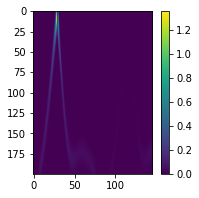

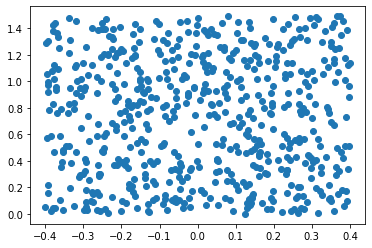

In [15]:
rand_index = np.random.choice(X.shape[0])
plt.figure(figsize=[3, 3])
plt.imshow(X[rand_index][...,0])
plt.colorbar()

plt.figure()
plt.scatter(y[:,0], y[:,1])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Train set size", X_train.shape)
print("Test set size", X_test.shape)


Train set size (480, 200, 146, 1)
Test set size (120, 200, 146, 1)


In [18]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=50,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

n_targets = y_train.shape[1]
w = X_train.shape[1]
q = X_train.shape[2]

# Input for variable-length sequences of integers
inputs = Input(shape=(w, q, 1))
x = inputs
# Embed each integer in a 3-dimensional vector
# x = layers.Embedding(nvocab, 3, input_length=nenergies)(x)
# Add 2 bidirectional LSTMs
x = Conv2D(8, (3, 3), padding='same', activation='relu', kernel_initializer='normal')(x)
x = Conv2D(8, (3, 3), padding='same', activation='relu', kernel_initializer='normal')(x)
x = MaxPool2D(3)(x)
x = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='normal')(x)
x = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='normal')(x)
x = MaxPool2D(3)(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='normal')(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='normal')(x)
x = MaxPool2D(3)(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='normal')(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='normal')(x)
x = MaxPool2D(3)(x)

# Add a classifier
x = Flatten()(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(n_targets, activation="linear")(x)



In [19]:
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 146, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 146, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 146, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 66, 48, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 66, 48, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 66, 48, 16)        2320      
                                                             

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mse", metrics=["mse"])
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1, verbose = 0, callbacks=[early_stopping_monitor])
model.save('../models/square_lattice_cnn')

Epoch 1/50
14/14 - 1s - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0275 - val_mse: 0.0275 - 1s/epoch - 98ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0038 - val_mse: 0.0038 - 183ms/epoch - 13ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0024 - val_mse: 0.0024 - 195ms/epoch - 14ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0011 - mse: 0.0011 - val_loss: 3.1778e-04 - val_mse: 3.1778e-04 - 212ms/epoch - 15ms/step
Epoch 5/50
14/14 - 0s - loss: 4.1558e-04 - mse: 4.1558e-04 - val_loss: 2.2972e-04 - val_mse: 2.2972e-04 - 188ms/epoch - 13ms/step
Epoch 6/50
14/14 - 0s - loss: 2.1704e-04 - mse: 2.1704e-04 - val_loss: 1.6731e-04 - val_mse: 1.6731e-04 - 186ms/epoch - 13ms/step
Epoch 7/50
14/14 - 0s - loss: 1.4449e-04 - mse: 1.4449e-04 - val_loss: 1.2771e-04 - val_mse: 1.2771e-04 - 179ms/epoch - 13ms/step
Epoch 8/50
14/14 - 0s - loss: 1.2251e-04 - mse: 1.2251e-04 - val_loss: 1.2606e-04 - val_mse: 1.2606e-04 - 162ms/epoch - 12ms/step
Epoch 9/50
14/14 - 

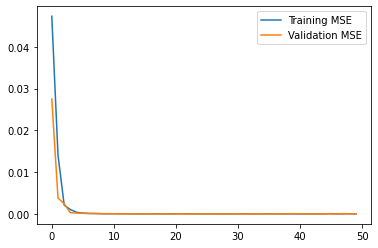

In [43]:
train_mse = history.history['mse']
val_mse = history.history['val_mse']

plt.plot(train_mse, label = 'Training MSE')
plt.plot(val_mse, label = 'Validation MSE')
plt.legend()
plt.show()

R squared:  0.9989585289313054


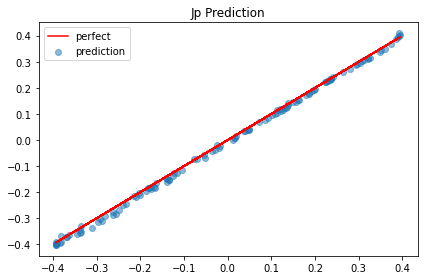

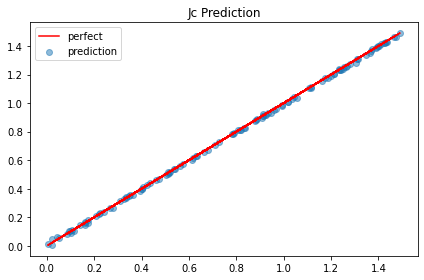

In [39]:
# Load model 
model = tf.keras.models.load_model('../models/square_lattice_cnn')

# Make prediction on test set (simulated)
y_pred = model.predict(X_test)
score_plot(y_pred, y_test)